# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## 0. Define the parameters of the model (0.5 pts)

In [2]:
def generate_gaussian_obs(mu, sigma, x_range = [0, 10], num_samples = 1000):
    obs = []
    cb = np.linspace(x_range[0], x_range[1], num_samples)
    obs = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(cb - mu)**2 / (2 * sigma**2))

    return obs, cb

In [3]:
# INSERT CODE HERE
rewards = {0:{0: 1, 1: 0, 2: -0.1}, 1:{0: 0, 1: 1, 2: -0.1}, 2: {0: 1, 1: 0}, 3:{0: 0, 1: 1}} # 0 = L, 1 = R first beta and then alpha 

p_a = [0.5, 0.5] # Prior
p_b = [0.5, 0.5] # Prior

cb = np.linspace(0, 10, 1000)
ca = np.linspace(0, 10, 1000)

mu = [6, 4]
sigma = 1
obs_a = [] # Likelihood
obs_b = [] # Likelihood

for i, m in enumerate(mu): 
    gaussian_values_a, cb = generate_gaussian_obs(m, sigma, x_range = [0, 10])
    obs_a.append(gaussian_values_a)
    gaussian_values_b, cb = generate_gaussian_obs(m, sigma, x_range = [0, 10])
    obs_b.append(gaussian_values_b)

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state'). 

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [4]:
# INSERT CODE BELOW
def update_belief_state_beta(obs_b, p_b):
    p_cb_x3 = obs_b[0]
    p_cb_x4 = obs_b[1]

    p_x3_cb = (p_b[0] * p_cb_x3)/ ( (p_b[0] * p_cb_x3) + (p_b[1] * p_cb_x4))
    p_x4_cb = (p_b[1] * p_cb_x4)/ ( (p_b[0] * p_cb_x3) + (p_b[1] * p_cb_x4))

    return p_x3_cb, p_x4_cb

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

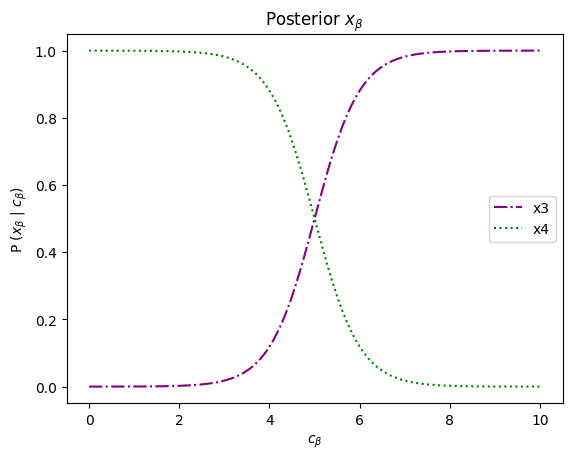

In [5]:
# INSERT CODE BELOW

p_x3_cb, p_x4_cb = update_belief_state_beta(obs_b, p_b)

plt.plot(cb,p_x3_cb, linestyle = '-.', color = 'purple', label = 'x3')
plt.plot(cb,p_x4_cb, linestyle = ':', color = 'green', label = 'x4')
plt.title('Posterior $x_\\beta$')
plt.xlabel('$c_\\beta$')
plt.ylabel('P ($x_\\beta$ | $c_\\beta$)')
plt.legend()
#plt.yticks([])
plt.show()

The posterior here shows the the belief state fo this case. As we discussd in class, the combination of both had to sum 1 (as it is a probability). Since the mean of the two different distributions are different, in this case the mean of the x4 gaussian distribution is 4, lower values than 5 (where they intersect and their prior probabilities aree p = 0.5 for both), will increase the belief state of x4, meaning that we would believe that we are in state x4, that the dots are moving to the right, while when the observations c_beta are higher than 5, the belief that  the observed stimulus belongs to x3 (dots moving to left) is higher, approaching 1 quickly. 

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [6]:
# INSERT CODE BELOW
def update_belief_state_alpha(obs_a, p_x3_cb, p_x4_cb): 
    p_ca_x1 = obs_a[0] # 1000 x 1 
    p_ca_x2 = obs_a[1] # 1000 x 1
    p_x1_cacb_x3 = np.zeros((1000, 1000))
    p_x2_cacb_x4 = np.zeros((1000, 1000))
    for cb in range(1000): 
        for ca in range(1000):
            p_x1_cacb_x3[cb, ca] = p_ca_x1[ca] * p_x3_cb[cb]
            p_x2_cacb_x4[cb, ca] = p_ca_x2[ca] * p_x4_cb[cb]

    p_x1_cacb = p_x1_cacb_x3 / (p_x1_cacb_x3 + p_x2_cacb_x4)
    p_x2_cacb = p_x2_cacb_x4 / (p_x1_cacb_x3 + p_x2_cacb_x4)
    
    return p_x1_cacb, p_x2_cacb


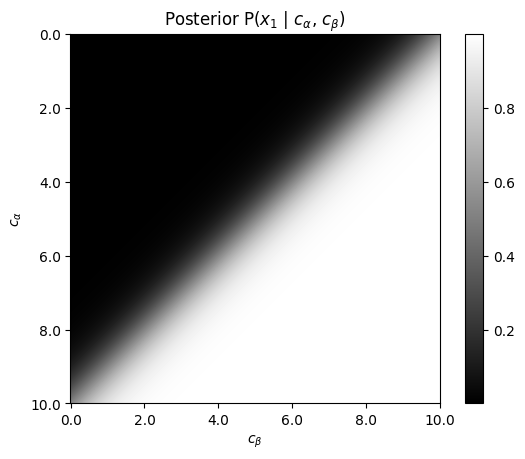

In [7]:
p_x1_cacb, p_x2_cacb = update_belief_state_alpha(obs_a, p_x3_cb, p_x4_cb)
#  extent = [0, 10, 10, 0]
plt.imshow(p_x1_cacb, cmap='gray')
plt.colorbar()
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(1000//10), ticks)
plt.yticks(ticks*(1000//10), ticks)
plt.title('Posterior P($x_1$ | $c_\\alpha$, $c_\\beta$)')
plt.xlabel('$c_\\beta$')
plt.ylabel('$c_\\alpha$')
#plt.yticks([])
plt.show()

For this second case, we have added one extra observation c_alpha. We can only get to c alpha when the observer has decided to choose action C . In this case, graph 9.B shows the probability of being in state x1, which we can only get to when we are in state x3 in the first observations c_beta. As the colorbar shows, white in this graph shows the probability of 1 and black shows the probability of 0. Values inbetween those are shown in the diagonal, where the uncertainty is highest. This can happen when we are in the case where both the stimuli are 5, as mentioned in the plot before, the observer will not know which distribution it could have come from because the likelihood probability is equal, while if the stimuli were both higher than 5, most likely it can from distribution x1 and vice versa.

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy'). 

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

Since at the end of the possible states, there are only two actions, which are both followed immediately by rewards. THis in turn means that to calculate the expected value of rewards at alpha we will only need the belief state and the reward, while to calculate the same at stage beta, we will need the values at alpha. All in all, we can calculate the values at stage alpha independently but we need those values to calculate the same at beta. 

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

Text(0, 0.5, '$c_\\alpha$')

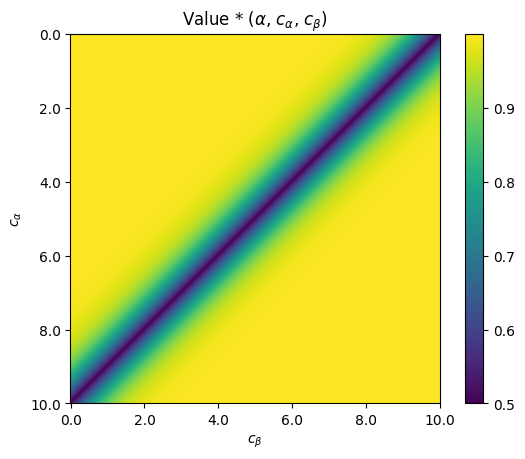

In [8]:
# INSERT CODE BELOW
def best_a_alpha(p_x1_cacb, p_x2_cacb, rewards): 
    v_a_ca_cb = np.zeros((1000, 1000))
    for cb in range(1000): 
        for ca in range(1000): 
            v_a_ca_cb[cb, ca] = np.max([p_x1_cacb[cb, ca]*rewards[0][0], p_x2_cacb[cb, ca]* rewards[1][1]])
    return v_a_ca_cb

v_a_ca_cb = best_a_alpha(p_x1_cacb, p_x2_cacb, rewards)

# Plot 
plt.imshow(v_a_ca_cb)
plt.colorbar()
plt.title('Value * ($\\alpha$, $c_\\alpha$, $c_\\beta$)')
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(1000//10), ticks)
plt.yticks(ticks*(1000//10), ticks)
plt.xlabel('$c_\\beta$')
plt.ylabel('$c_\\alpha$')

The plot here shows what, taking into account the two observations at stage beta and stage alpha, the Q values are at stage alpha. As before in plot 9.B we can see how the the diagonal is the part with the highest uncertainty (lower values as shown inn the colorbar), while the rest has a value very close to 1, if not 1. The biggest reward is equal to 1, and when the state is know thanks to the belief states, the final rewards of 1 will be obtained. However, when the state is unknown and uncertain, the final action will be guessed and a reward will be obtained half of the time. 

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

Text(0, 0.5, '$c_\\alpha$')

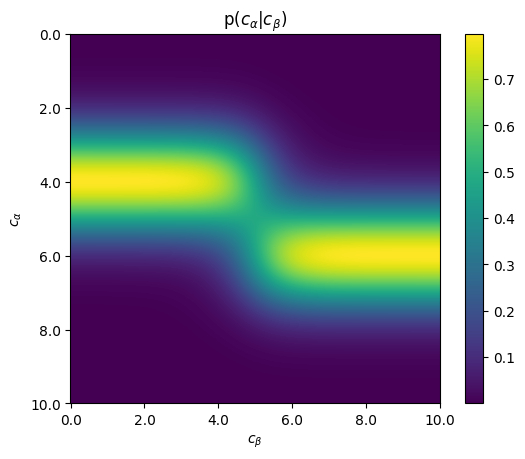

In [9]:
# INSERT CODE BELOW
def prob_ca_cb(obs_a, obs_b): 
    p_cagcb = np.zeros((1000, 1000))
    for cb in range(1000): 
        for ca in range(1000): 
            p_ca_cb = obs_a[0][ca] * obs_b[0][cb] + obs_a[1][ca] * obs_b[1][cb]
            p_cb = 0.5 * (obs_b[0][cb] + obs_b[1][cb])
            p_cagcb[ca, cb] = p_ca_cb / p_cb

    return p_cagcb

p_cagcb = prob_ca_cb(obs_a, obs_b)
plt.imshow(p_cagcb)
#plt.imshow(p_cagcb, extent=[0, 10, 0, 10])
ticks = np.linspace(0,10,6)
plt.xticks(ticks*(1000//10), ticks)
plt.yticks(ticks*(1000//10), ticks)
plt.colorbar()
plt.title('p($c_\\alpha$|$c_\\beta$)')
plt.xlabel('$c_\\beta$')
plt.ylabel('$c_\\alpha$')

The plot here illustrates the likelihood of getting a c_alpha given a c_beta. For example, we can see how the values c_alpha = 1 or c = 9 are highly unlikely for any kind of  c_beta because the values shown in the plot are very close to 0. On the other hand, for values of c_beta higher than 6, we can see that a value of c_alpha = 6  is very likely, and for values lower than 4, a c_alpha = 4 is very likely. This has all to do with the gaussian distribution nature of the observations. At c_beta = 5, the uncertainty is high, as shown in the previous plots, because we are not sure which distribution the stimulus belongs to. This is usually due to the fact that c_beta gives info about the distributions

### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution. 

In [10]:
def q_beta(obs_b, p_b, rewards): # For L and R
    qs = np.zeros((3, 1000))
    b_x3, b_x4 = update_belief_state_beta(obs_b, p_b)
    qs[0] = b_x3 * rewards[0][0]
    qs[1] = b_x4 * rewards[1][1]
    return qs, b_x3, b_x4

def integration(a, b_x3, b_x4, rewards):
    b_x1, b_x2 = update_belief_state_alpha(obs_a, b_x3, b_x4)
    val = best_a_alpha(b_x1, b_x2, rewards)
    return val * a
   
def qc_beta(b_x3, b_x4, obs_a, ca, rewards): 
    int_vacacb_1 = integration(obs_a[0], b_x3, b_x4, rewards)
    int_vacacb_2 = integration(obs_a[1], b_x3, b_x4, rewards)

    result_1 = np.trapz(int_vacacb_1, ca, 0.001)
    result_2 = np.trapz(int_vacacb_2, ca, 0.001)

    v_a_cb = b_x3 * result_1 + b_x4 * result_2
    qs_c = -0.1 + v_a_cb # C
    return qs_c



Text(0, 0.5, 'Value')

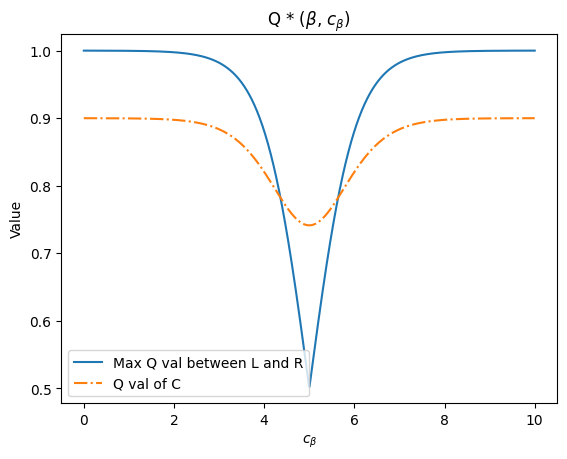

In [11]:
# INSERT CODE BELOW
qval_beta_cb, b_x3, b_x4 = q_beta(obs_b, p_b, rewards)
qval_beta_cb[2, :] = qc_beta(b_x3, b_x4, obs_a, ca, rewards)

max = np.max(qval_beta_cb[:2, :], axis = 0)
plt.plot(cb, max, linestyle = '-', label = 'Max Q val between L and R')
plt.plot(cb, qval_beta_cb[2, :], linestyle = '-.', label = 'Q val of C')
plt.legend()
plt.title('Q * ($\\beta$, $c_\\beta$)')
plt.xlabel('$c_\\beta$')
plt.ylabel('Value')

The best action at beta will be the one with the highest value. In this case as we can see, besides the gap around 4.5 < c < 5.5, the best action will be either L and R because the expected value of choosing either will be higher than of choosing C. However, in the just mentioned gap, choosing action C has a much higher expected value than either L and R. This is due to the fact that the uncertainty around 5 is so high, that the probability of making the right choice is lower and therefore getting more information (choosing C and getting into states x1 or x2) will lead to a higher reward. 

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter. 

Text(0, 0.5, 'Value')

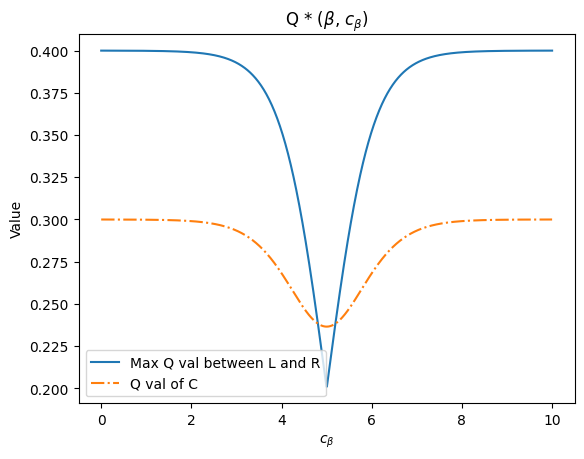

In [12]:
# INSERT CODE BELOW
rewards_2 = {0:{0: 0.4, 1: 0, 2: -0.1}, 1:{0: 0, 1: 0.4, 2: -0.1}, 2: {0: 1, 1: 0}, 3:{0: 0, 1: 1}} # 0 = L, 1 = R first beta and then alpha 

qval_beta_cb_2, b_x3_2, b_x4_2, = q_beta(obs_b, p_b, rewards_2)
qval_beta_cb_2[2, :] = qc_beta(b_x3_2, b_x4_2, obs_a, ca, rewards_2)

max_2 = np.max(qval_beta_cb_2[:2, :], axis = 0)
plt.plot(cb, max_2, linestyle = '-', label = 'Max Q val between L and R')
plt.plot(cb, qval_beta_cb_2[2, :], linestyle = '-.', label = 'Q val of C')
plt.legend()
plt.title('Q * ($\\beta$, $c_\\beta$)')
plt.xlabel('$c_\\beta$')
plt.ylabel('Value')

Text(0, 0.5, 'Value')

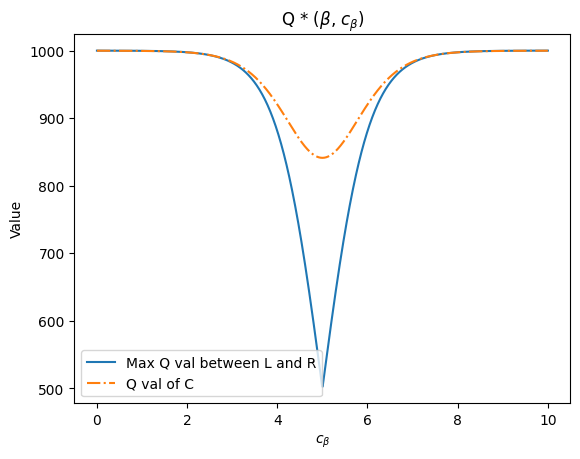

In [13]:
rewards_3 = {0:{0: 1000, 1: 0, 2: -0.1}, 1:{0: 0, 1: 1000, 2: -0.1}, 2: {0: 1, 1: 0}, 3:{0: 0, 1: 1}} # 0 = L, 1 = R first beta and then alpha 

qval_beta_cb_2, b_x3_2, b_x4_2, = q_beta(obs_b, p_b, rewards_3)
qval_beta_cb_2[2, :] = qc_beta(b_x3_2, b_x4_2, obs_a, ca, rewards_3)

max_2 = np.max(qval_beta_cb_2[:2, :], axis = 0)
plt.plot(cb, max_2, linestyle = '-', label = 'Max Q val between L and R')
plt.plot(cb, qval_beta_cb_2[2, :], linestyle = '-.', label = 'Q val of C')
plt.legend()
plt.title('Q * ($\\beta$, $c_\\beta$)')
plt.xlabel('$c_\\beta$')
plt.ylabel('Value')

In this case, if the ratio between what we loose (-0.1 when choosing action C) and the amount of reward is high (1000:0.1), the range of observation at which choosing C would be best would increase, as it wouldn't matter losing 0.1 if we gain 1000 as reward, and the opposite would happen if the reward was decreased to around 0.4, the range of observation beta where choosing C would be best would be decreased.